In [13]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision import datasets, models, transforms
from PIL import Image
import requests
from io import BytesIO
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from urllib.request import urlopen

# Note: In this code, sometimes i "repeated myself" which is not a good practice, but i had to because
# i wrote this code in diffrenet time sluts and did not want to run some cells again and remover their outputs, as they took a lot of time. (pre-processings for example)

# Part 1: MobileNet

In [15]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True)


Archiyecture: MobileNetV2 is a efficient model designed for use on devices with limited resources, like smartphones (That explains the name). It uses a special structure called an "inverted residual block". This block has three parts: first, it uses a depthwise separable convolution to reduce the amount of work needed. Then, it expands the features to learn more information, and finally, it reduces the features back to a smaller size without adding extra complexity. The model also uses skip connections from ResNet, which help the model learn more easily by allowing information to pass through without being changed. In the end, it has a fully connected layer to produce the final output. This design helps MobileNetV2 perform well while using fewer resources.

Input Dimention: without considering the batch size, the input dimention is 3 * 224 * 224

Pre-Processing: Preprocessing for MobileNetV2 includes resizing the image to 224x224 pixels, normalizing pixel values with specific mean and standard deviation, and converting the image to a tensor. Data augmentation is often used during training to improve performance. These steps prepare the image for the model.

Output Dimention: 1000 (Without considering bacth size)

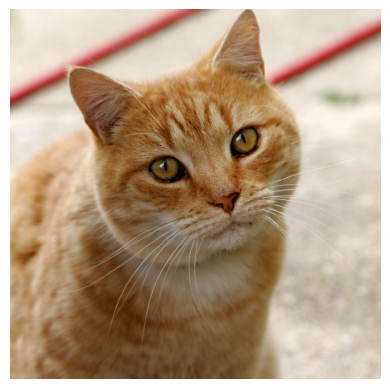

tiger_cat: 47.44%
Egyptian_cat: 37.61%
lynx: 6.91%


In [16]:
mobilenet_v2.eval()

# Download a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocessing the image for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),               # Resize to 256
    transforms.CenterCrop(224),           # Crop to 224x224
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

# Move image tensor to the same device as the model (CPU in this case)
img_tensor = img_tensor.to(torch.device("cpu"))

# Get the output from MobileNetV2
with torch.no_grad():
    output = mobilenet_v2(img_tensor)

# Get the top 3 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Load the class labels for ImageNet
LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels = requests.get(LABELS_URL).json()

# Print the names of the top 3 predicted classes
for i in range(3):
    class_id = top3_catid[i].item()
    class_name = labels[str(class_id)][1]
    prob = top3_prob[i].item()
    print(f"{class_name}: {prob * 100:.2f}%")


100%|██████████| 345M/345M [00:06<00:00, 56.5MB/s]


Extracting oxford102/flowers-102/102flowers.tgz to oxford102/flowers-102


100%|██████████| 502/502 [00:00<00:00, 216kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 17.5MB/s]


Epoch [1/10]
Train Loss: 4.3971, Train Accuracy: 11.27%
Val Loss: 3.2527, Val Accuracy: 42.35%
Epoch [2/10]
Train Loss: 2.3853, Train Accuracy: 67.06%
Val Loss: 2.0541, Val Accuracy: 72.55%
Epoch [3/10]
Train Loss: 1.3556, Train Accuracy: 87.35%
Val Loss: 1.4745, Val Accuracy: 81.27%
Epoch [4/10]
Train Loss: 0.8291, Train Accuracy: 94.31%
Val Loss: 1.1639, Val Accuracy: 83.63%
Epoch [5/10]
Train Loss: 0.5590, Train Accuracy: 96.86%
Val Loss: 0.9843, Val Accuracy: 86.27%
Epoch [6/10]
Train Loss: 0.4070, Train Accuracy: 98.43%
Val Loss: 0.8688, Val Accuracy: 86.96%
Epoch [7/10]
Train Loss: 0.3149, Train Accuracy: 99.22%
Val Loss: 0.8049, Val Accuracy: 86.76%
Epoch [8/10]
Train Loss: 0.2340, Train Accuracy: 99.51%
Val Loss: 0.7434, Val Accuracy: 88.14%
Epoch [9/10]
Train Loss: 0.1956, Train Accuracy: 100.00%
Val Loss: 0.7027, Val Accuracy: 87.65%
Epoch [10/10]
Train Loss: 0.1563, Train Accuracy: 100.00%
Val Loss: 0.6720, Val Accuracy: 88.33%


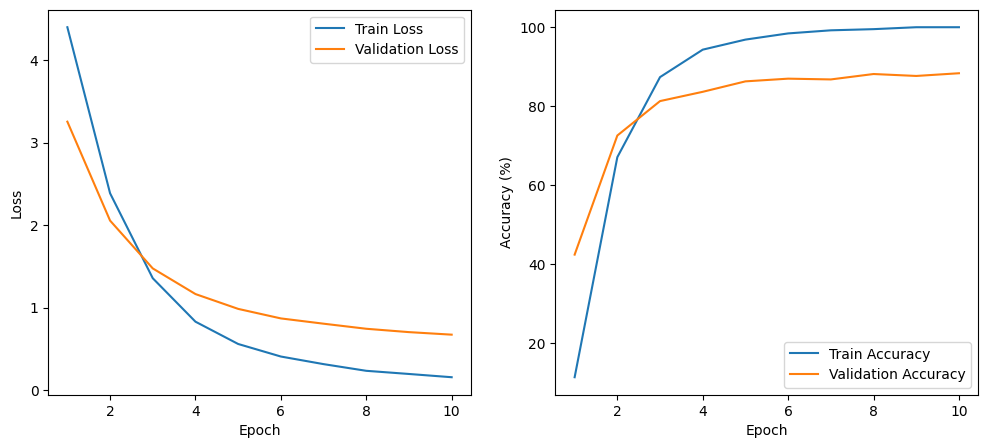

In [17]:
# Define image transforms for both training and validation datasets
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop to 224x224 for MobileNetV2 input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Define the path to store the Oxford 102 Flower dataset
data_dir = './oxford102'  # Directory where the dataset will be downloaded

# Load the training and validation datasets
train_dataset = datasets.Flowers102(root=data_dir, split='train', transform=preprocess, download=True)
val_dataset = datasets.Flowers102(root=data_dir, split='val', transform=preprocess, download=True)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pretrained MobileNetV2
mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')

# Freeze all layers in MobileNetV2
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Modify the final fully connected layers to classify 102 classes (Oxford 102 flowers)
num_ftrs = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, 102)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier[1].parameters(), lr=0.001)

# Training and validation loops
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    mobilenet_v2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = mobilenet_v2(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    mobilenet_v2.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = mobilenet_v2(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for validation
    val_loss = running_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the loss and accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [18]:
# Function to evaluate the model on a given dataset
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy
    avg_loss = running_loss / len(dataloader)
    accuracy = (correct / total) * 100
    return avg_loss, accuracy

# Load the test dataset (assuming the test set is available in the same way as train/val)
test_dataset = datasets.Flowers102(root=data_dir, split='test', transform=preprocess, download=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on the Train Set
train_loss, train_accuracy = evaluate_model(mobilenet_v2, train_loader, criterion, device)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Evaluate on the Validation Set (already done during training, but we can do it here too)
val_loss, val_accuracy = evaluate_model(mobilenet_v2, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Evaluate on the Test Set
test_loss, test_accuracy = evaluate_model(mobilenet_v2, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Train Loss: 0.0767, Train Accuracy: 100.00%
Validation Loss: 0.6720, Validation Accuracy: 88.33%
Test Loss: 0.7671, Test Accuracy: 85.54%


# Part 2: VGG16

In [19]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.8MB/s]


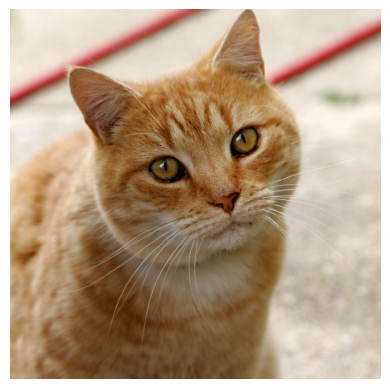

Egyptian_cat: 48.24%
tiger_cat: 40.19%
tabby: 6.66%


In [20]:
# Load VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()  # Set to evaluation mode

# Download a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocessing the image for VGG16
preprocess = transforms.Compose([
    transforms.Resize(256),               # Resize to 256
    transforms.CenterCrop(224),           # Crop to 224x224
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (same as MobileNetV2)
])

img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

# Move image tensor to the same device as the model (CPU in this case)
img_tensor = img_tensor.to(torch.device("cpu"))

# Get the output from VGG16
with torch.no_grad():
    output = vgg16(img_tensor)

# Get the top 3 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Load the class labels for ImageNet
LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels = requests.get(LABELS_URL).json()

# Print the names of the top 3 predicted classes
for i in range(3):
    class_id = top3_catid[i].item()
    class_name = labels[str(class_id)][1]
    prob = top3_prob[i].item()
    print(f"{class_name}: {prob * 100:.2f}%")

Epoch [1/10]
Train Loss: 3.7792, Train Accuracy: 21.18%
Val Loss: 2.1896, Val Accuracy: 59.90%
Epoch [2/10]
Train Loss: 1.2669, Train Accuracy: 75.59%
Val Loss: 1.4301, Val Accuracy: 71.37%
Epoch [3/10]
Train Loss: 0.7011, Train Accuracy: 87.75%
Val Loss: 1.1947, Val Accuracy: 73.92%
Epoch [4/10]
Train Loss: 0.4580, Train Accuracy: 93.14%
Val Loss: 1.1032, Val Accuracy: 74.80%
Epoch [5/10]
Train Loss: 0.3546, Train Accuracy: 94.80%
Val Loss: 1.0236, Val Accuracy: 76.67%
Epoch [6/10]
Train Loss: 0.2596, Train Accuracy: 96.86%
Val Loss: 0.9824, Val Accuracy: 76.76%
Epoch [7/10]
Train Loss: 0.2167, Train Accuracy: 97.65%
Val Loss: 0.9422, Val Accuracy: 77.45%
Epoch [8/10]
Train Loss: 0.1787, Train Accuracy: 98.53%
Val Loss: 0.9279, Val Accuracy: 77.25%
Epoch [9/10]
Train Loss: 0.1467, Train Accuracy: 98.33%
Val Loss: 0.9084, Val Accuracy: 77.25%
Epoch [10/10]
Train Loss: 0.1244, Train Accuracy: 99.41%
Val Loss: 0.8976, Val Accuracy: 76.76%


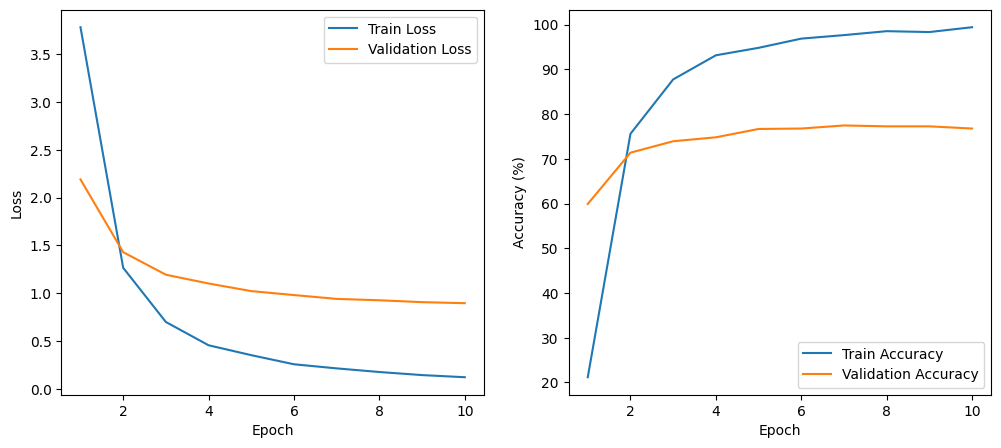

In [21]:
# Define image transforms for both training and validation datasets
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop to 224x224 for VGG16 input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Define the path to store the Oxford 102 Flower dataset
data_dir = './oxford102'  # Directory where the dataset will be downloaded

# Load the training and validation datasets with download option
train_dataset = datasets.Flowers102(root=data_dir, split='train', transform=preprocess, download=True)
val_dataset = datasets.Flowers102(root=data_dir, split='val', transform=preprocess, download=True)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 1: Load pretrained VGG16 and freeze its parameters
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers in VGG16
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the final fully connected layers to classify 102 classes (Oxford 102 flowers)
num_ftrs = vgg16.classifier[6].in_features  # Get the number of input features to the final layer
vgg16.classifier[6] = nn.Linear(num_ftrs, 102)  # Replace the final layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Step 2: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# Step 3: Training and validation loops
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    vgg16.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    vgg16.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = vgg16(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for validation
    val_loss = running_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the loss and accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Step 4: Plot the training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [22]:
# Step 1: Define image transforms for preprocessing (resize, crop, normalize)
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256px
    transforms.CenterCrop(224),  # Crop to 224x224 (center-cropping)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Step 2: Load the datasets for final evaluation (train, validation, test)
# Assuming you have a test dataset as well (if not, you need to split part of the train set for testing)
train_dataset = datasets.Flowers102(root=data_dir, split='train', transform=preprocess, download=True)
val_dataset = datasets.Flowers102(root=data_dir, split='val', transform=preprocess, download=True)
test_dataset = datasets.Flowers102(root=data_dir, split='test', transform=preprocess, download=True)  # Assuming test dataset exists

# Step 3: Create DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No need to shuffle for final evaluation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 4: Calculate final loss and accuracy for each dataset
def calculate_loss_and_accuracy(loader, model, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(loader)
    accuracy = (correct / total) * 100
    return avg_loss, accuracy

# Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Calculate for train set
train_loss, train_accuracy = calculate_loss_and_accuracy(train_loader, vgg16, criterion, device)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Calculate for validation set
val_loss, val_accuracy = calculate_loss_and_accuracy(val_loader, vgg16, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Calculate for test set
test_loss, test_accuracy = calculate_loss_and_accuracy(test_loader, vgg16, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Train Loss: 0.0680, Train Accuracy: 99.90%
Validation Loss: 0.8976, Validation Accuracy: 76.76%
Test Loss: 0.9984, Test Accuracy: 74.99%


# Part3: ResNet50

In [23]:
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


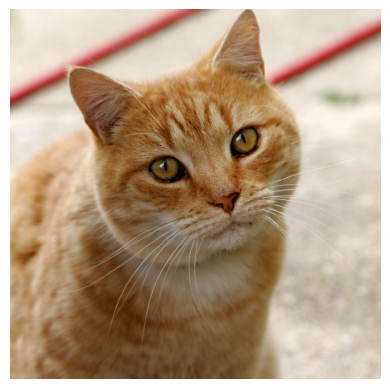

tiger_cat: 57.37%
Egyptian_cat: 19.67%
tabby: 16.93%


In [26]:
# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()  # Set to evaluation mode

# Download a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocessing the image for ResNet50
preprocess_resnet50 = transforms.Compose([
    transforms.Resize(256),               # Resize to 256
    transforms.CenterCrop(224),           # Crop to 224x224
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (same as VGG16)
])

img_tensor = preprocess_resnet50(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Move image tensor to the same device as the model (CPU in this case)
img_tensor = img_tensor.to(torch.device("cpu"))

# Get the output from ResNet50
with torch.no_grad():
    output = resnet50(img_tensor)

# Get the top 3 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Load the class labels for ImageNet
LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels = requests.get(LABELS_URL).json()

# Print the names of the top 3 predicted classes
for i in range(3):
    class_id = top3_catid[i].item()
    class_name = labels[str(class_id)][1]
    prob = top3_prob[i].item()
    print(f"{class_name}: {prob * 100:.2f}%")

In [27]:
# Define image transforms for both training and validation datasets
preprocess_resnet50 = transforms.Compose([
    transforms.Resize(256),               # Resize the image to 256x256
    transforms.CenterCrop(224),           # Crop to 224x224 for ResNet50 input
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Define the path to store the Oxford 102 Flower dataset
data_dir = './oxford102'  # Directory where the dataset will be downloaded

# Load the training and validation datasets with download option
train_dataset = datasets.Flowers102(root=data_dir, split='train', transform=preprocess_resnet50, download=True)
val_dataset = datasets.Flowers102(root=data_dir, split='val', transform=preprocess_resnet50, download=True)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)   # No shuffle for validation

# Load pretrained ResNet50 and freeze its parameters
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers in ResNet50 except the fully connected layer
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final fully connected layers to classify 102 classes (Oxford 102 flowers)
num_ftrs = resnet50.fc.in_features  # Get the number of input features to the final layer
resnet50.fc = nn.Linear(num_ftrs, 102)  # Replace the final layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)  # Optimizer only for final layer, adjust if fine-tuning the whole model

# Training and validation loops
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    resnet50.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = resnet50(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    resnet50.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = resnet50(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy for validation
    val_loss = running_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/10
Train Loss: 4.5331, Train Accuracy: 10.88%
Validation Loss: 3.3557, Validation Accuracy: 30.00%
Epoch 2/10
Train Loss: 2.5042, Train Accuracy: 59.80%
Validation Loss: 2.1428, Validation Accuracy: 64.12%
Epoch 3/10
Train Loss: 1.4770, Train Accuracy: 80.98%
Validation Loss: 1.5801, Validation Accuracy: 74.80%
Epoch 4/10
Train Loss: 0.8868, Train Accuracy: 93.92%
Validation Loss: 1.2181, Validation Accuracy: 80.10%
Epoch 5/10
Train Loss: 0.5824, Train Accuracy: 97.84%
Validation Loss: 1.0239, Validation Accuracy: 81.86%
Epoch 6/10
Train Loss: 0.4164, Train Accuracy: 98.82%
Validation Loss: 0.9258, Validation Accuracy: 83.43%
Epoch 7/10
Train Loss: 0.3098, Train Accuracy: 99.22%
Validation Loss: 0.8272, Validation Accuracy: 85.78%
Epoch 8/10
Train Loss: 0.2262, Train Accuracy: 99.71%
Validation Loss: 0.7809, Validation Accuracy: 84.80%
Epoch 9/10
Train Loss: 0.1860, Train Accuracy: 99.80%
Validation Loss: 0.7381, Validation Accuracy: 86.18%
Epoch 10/10
Train Loss: 0.1528, Train

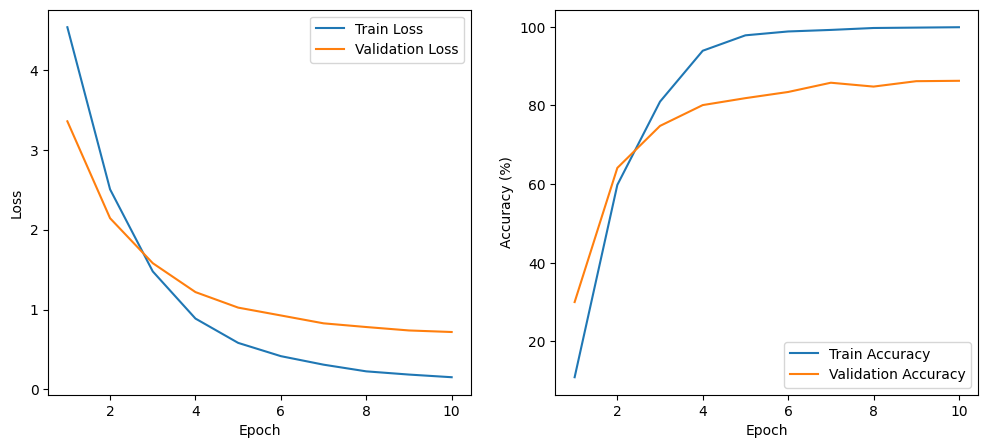

In [29]:
# Step 4: Plot the training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [28]:
# Function to calculate loss and accuracy over a given dataset
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Track the loss
            running_loss += loss.item()

            # Get predictions and calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = (correct / total) * 100

    return avg_loss, accuracy

# Calculate loss and accuracy for training, validation, and test sets
train_loss, train_accuracy = evaluate_model(resnet50, train_loader, criterion, device)
val_loss, val_accuracy = evaluate_model(resnet50, val_loader, criterion, device)
test_loss, test_accuracy = evaluate_model(resnet50, test_loader, criterion, device)  # Assuming test_loader is defined

# Print results
print("Performance of the trained model:")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Performance of the trained model:
Train Loss: 0.0840, Train Accuracy: 100.00%
Validation Loss: 0.7186, Validation Accuracy: 86.27%
Test Loss: 0.7835, Test Accuracy: 84.21%


# Paer 4: Comparison and Number of Parameters

test accuracy:

MobileNet: 85.54 / VGG: 74.99 / ResNet: 84.21

As you can see mobile net has the best performance over test set

In [32]:
# Function to calculate total and trainable parameters
def get_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Get parameters for each model
mobilenet_params = get_model_parameters(mobilenet_v2)
vgg_params = get_model_parameters(vgg16)
resnet_params = get_model_parameters(resnet50)

# Prepare data for plotting
models_names = ['MobileNet', 'VGG16', 'ResNet50']
num_total_params = [mobilenet_params[0], vgg_params[0], resnet_params[0]]
num_trainable_params = [mobilenet_params[1], vgg_params[1], resnet_params[1]]

# Print results
models_names = ['MobileNet', 'VGG16', 'ResNet50']
num_total_params = [mobilenet_params[0], vgg_params[0], resnet_params[0]]
num_trainable_params = [mobilenet_params[1], vgg_params[1], resnet_params[1]]

print("Model Parameters:")
for name, total, trainable in zip(models_names, num_total_params, num_trainable_params):
    print(f"{name}: Total Parameters = {total}, Trainable Parameters = {trainable}")

Model Parameters:
MobileNet: Total Parameters = 2354534, Trainable Parameters = 130662
VGG16: Total Parameters = 134678438, Trainable Parameters = 417894
ResNet50: Total Parameters = 23717030, Trainable Parameters = 208998


# Part 5: Training MobileNet from the scratch

Epoch 1/10, Train Loss: 4.8869, Train Acc: 1.57%, Valid Loss: 4.8814, Valid Acc: 0.98%
Epoch 2/10, Train Loss: 4.2661, Train Acc: 3.82%, Valid Loss: 5.2306, Valid Acc: 1.08%
Epoch 3/10, Train Loss: 3.9283, Train Acc: 6.37%, Valid Loss: 4.4404, Valid Acc: 6.76%
Epoch 4/10, Train Loss: 3.6988, Train Acc: 9.12%, Valid Loss: 4.0048, Valid Acc: 9.22%
Epoch 5/10, Train Loss: 3.3677, Train Acc: 12.35%, Valid Loss: 4.7492, Valid Acc: 7.16%
Epoch 6/10, Train Loss: 3.2583, Train Acc: 16.08%, Valid Loss: 3.9325, Valid Acc: 12.25%
Epoch 7/10, Train Loss: 3.0608, Train Acc: 17.84%, Valid Loss: 3.8750, Valid Acc: 12.75%
Epoch 8/10, Train Loss: 2.8929, Train Acc: 20.49%, Valid Loss: 3.8593, Valid Acc: 14.02%
Epoch 9/10, Train Loss: 2.8068, Train Acc: 23.53%, Valid Loss: 4.4891, Valid Acc: 11.18%
Epoch 10/10, Train Loss: 2.5756, Train Acc: 28.24%, Valid Loss: 3.5809, Valid Acc: 17.06%


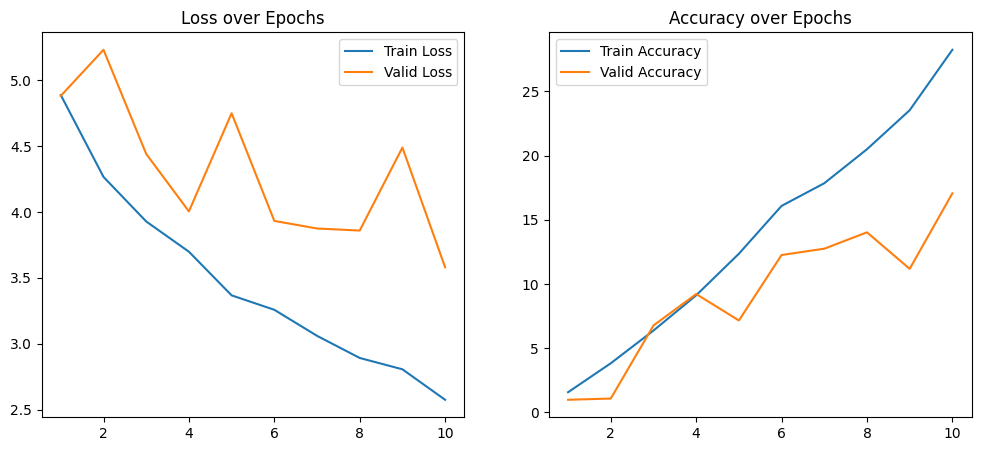

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MobileNet with random weights
model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(model.last_channel, 102)  # Adjust the output layer for 102 classes
model = model.to(device)

# Dataset preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=transform)
valid_dataset = datasets.Flowers102(root='data', split='val', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = (train_correct / len(train_loader.dataset)) * 100  # Accuracy as percentage
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation loop
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            valid_correct += (preds == labels).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_acc = (valid_correct / len(valid_loader.dataset)) * 100  # Accuracy as percentage
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

# Plot loss and accuracy
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, valid_loss_list, label='Valid Loss')
plt.legend()
plt.title('Loss over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, valid_acc_list, label='Valid Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


In [35]:
model.eval()
train_loss, train_correct = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

train_loss /= len(train_loader.dataset)
train_acc = (train_correct / len(train_loader.dataset)) * 100

# Validation final metrics
valid_loss, valid_correct = 0, 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        valid_correct += (preds == labels).sum().item()

valid_loss /= len(valid_loader.dataset)
valid_acc = (valid_correct / len(valid_loader.dataset)) * 100

# Test final metrics
test_loss, test_correct = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = (test_correct / len(test_loader.dataset)) * 100

# Print final results
print("\nFinal Metrics:")
print(f"Final Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
print(f"Final Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Final Metrics:
Final Train Loss: 2.3845, Train Accuracy: 31.27%
Final Validation Loss: 3.5809, Validation Accuracy: 17.06%
Final Test Loss: 3.9017, Test Accuracy: 12.26%


As you can see, after 10 epochs we have test accuracy of 12.26 % which is really low. If we increase the number of epochs, we would probebly get a higher number but i did not do that to prove a point, which is, with the same number of epochs, we can reach a very high accuracy usung TRANSFER LEARNING from above (all were more that 70%). It is obvoius that using a pre-trained feature extractor and training the classifier can speed up the process and help us reach a great performence.